# Linux for Health (LFH) - Pulse Demo

In [ ]:
# INSTRUCTIONS
# 1. Set the Raspberry Pi and LinuxONE hosts at the bottom of this cell
# 2. Proceed to running each cell sequentially

import requests
import json
import pandas as pd
import base64
from requests.auth import HTTPBasicAuth
from IPython.display import Image, display
from IPython.core.display import HTML
from ipywidgets import Dropdown, Text, Layout, FileUpload

# Set Raspberry Pi and LinuxOne hosts
pi_host="0.0.0.0"
linuxONE_host="0.0.0.0"

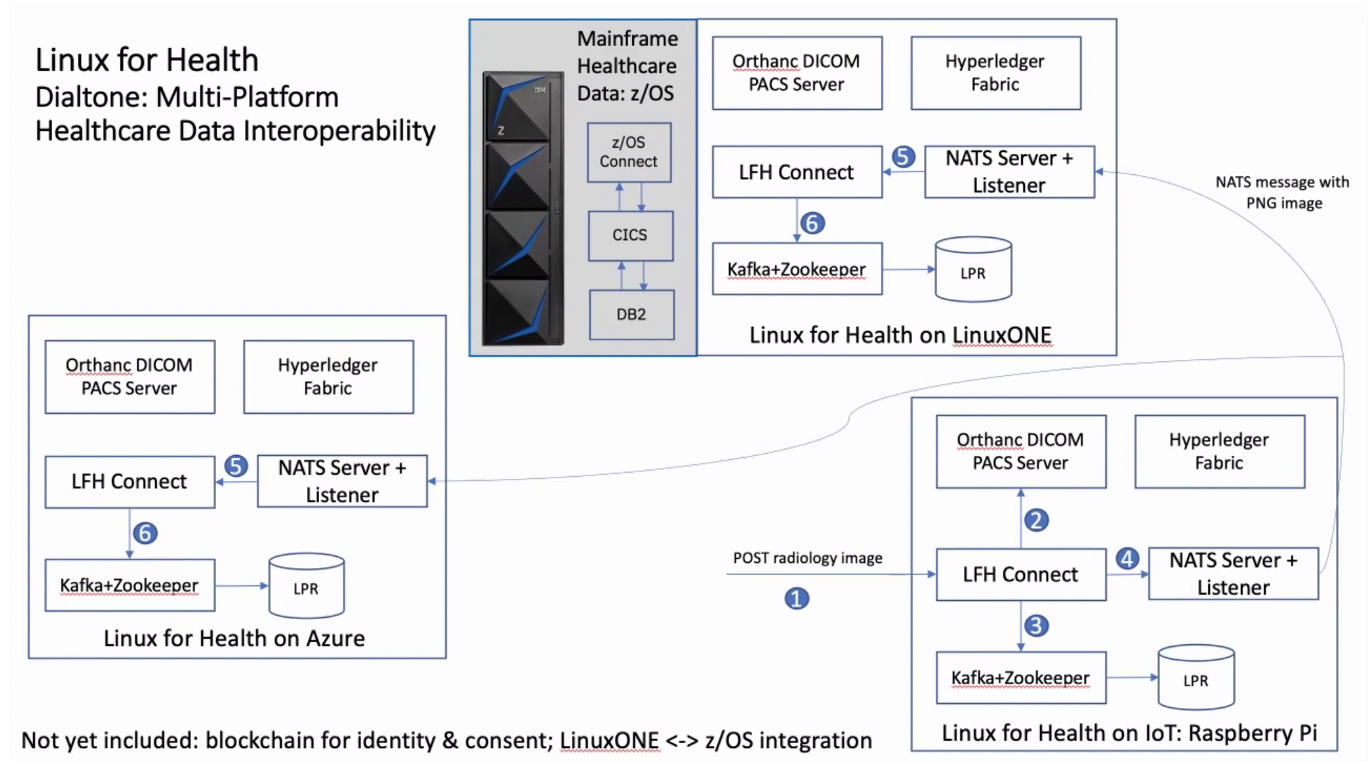

---

## 1. Select DICOM image to post to Raspberry Pi

In [ ]:
# Request dicom file for posting to lfh from user
FileUpload(multiple=False)

file_upload = FileUpload()

print("Select DICOM image file for upload:")
display(file_upload)

print('\nSelect the receiving endpoint below')

endpoint_0_localhost = "http://127.0.0.1:9090/orthanc/instances"

endpoint_0_text = Text(
    value=endpoint_0_localhost,
    placeholder='Enter post endpoint url',
    description='Url:',
    disabled=False,
    layout=Layout(width='30%')
)

def select_endpoint_0(change):
    endpoint_0_text.value=change.new

endpoint_0_menu = Dropdown(
    options=[("localhost",endpoint_0_localhost), ('Raspberry Pi',"http://" + pi_host + ":9090/orthanc/instances")],
    value=endpoint_0_localhost,
    # rows=10,
    description='Endpoint',
    disabled=False
)

endpoint_0_menu.observe(select_endpoint_0, names='value')

display(endpoint_0_menu)
display(endpoint_0_text)

In [ ]:
# Post dicom file to lfh

if file_upload.metadata:

    # Retrieve file upload content and post as requst body
    dicom_file = file_upload.value[file_upload.metadata[0]['name']]['content']

    resp = requests.post(endpoint_0_text.value, auth=HTTPBasicAuth('orthanc','orthanc'), data=dicom_file)

    if resp.ok:
        json_data = resp.json()
        print("File successfully posted - uuid:", json_data['meta']['uuid'])
        uuid = json_data['meta']['uuid']
    else:
        print("Post request failed - code: ", resp.status_code, " body: ", resp.text)
    
else:
    print("Please select file for upload")

## 2. Retrieve previously posted DICOM image from LinuxOne via LFH

In [ ]:
endpoint_1_localhost = "http://127.0.0.1:9000/topic/DICOM_IMAGE/messages?partition=0&offset=0&count=100&keyFormat=DEFAULT&format=DEFAULT"

endpoint_1_text = Text(
    value=endpoint_1_localhost,
    placeholder='Enter post endpoint url',
    description='Url',
    disabled=False,
    layout=Layout(width='75%')
)

def select_endpoint_1(change):
    endpoint_1_text.value=change.new

endpoint_1_menu = Dropdown(
    options=[("localhost",endpoint_1_localhost), ("LinuxOne","http://" + linuxONE_host + ":9000/topic/DICOM_IMAGE/messages?partition=0&offset=0&count=100&keyFormat=DEFAULT&format=DEFAULT")],
    #value=1,
    # rows=10,
    description='Endpoint',
    disabled=False
)

endpoint_1_menu.observe(select_endpoint_1, names='value')

print('\nSelect the endpoint below to retrieve the previously uploaded file')

display(endpoint_1_menu)
display(endpoint_1_text)

In [ ]:
# Display retrieved dicom file from a different host

resp = requests.get(endpoint_1_text.value, headers={"accept":"application/json"})

json_data = resp.json()

my_df = []

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{im}">'

for i in json_data:
    msg = i['message']
    msg_json = json.loads(msg)
    if uuid != msg_json['meta']['uuid']:
        continue
    data = msg_json['data']
    dec_data = base64.b64decode(data).decode('utf-8')
    img_json = json.loads(dec_data)
    image_str = base64.b64decode(img_json['image'])
    my_df.append([ msg_json['meta']['routeId'], msg_json['meta']['uuid'], img_json['image'] ])
    
my_df = pd.DataFrame(my_df, columns=['Route ID', 'UUID', 'Image'])

HTML(my_df.to_html(formatters={'Image': image_formatter}, escape=False))